In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import requests
from scipy.optimize import curve_fit, brentq
from scipy.stats import norm

In [39]:
def get_instruments(currency="BTC", kind="option"):
    """
    Fetches all instruments of a given kind for the specified currency.

    Parameters:
    currency (str): Currency symbol (e.g., "BTC", "ETH").
    kind (str): Instrument type ("option" or "future").

    Returns:
    list: A list of instrument dictionaries from the Deribit API.
    """
    url = f"https://www.deribit.com/api/v2/public/get_instruments?currency={currency}&kind={kind}"
    response = requests.get(url)
    return response.json()["result"]

def get_ticker(instrument_name):
    """
    Fetches ticker data for a specific instrument by name.

    Parameters:
    instrument_name (str): The full instrument name (e.g., "BTC-28JUN24-30000-C").

    Returns:
    dict: Ticker information including mark price, mark IV, bid/ask, etc.
    """
    url = f"https://www.deribit.com/api/v2/public/ticker?instrument_name={instrument_name}"
    response = requests.get(url)
    return response.json()["result"]

def get_deribit_index_price(currency="btc"):
    """
    Fetches the Deribit index price for the given coin/currency pair.
    
    Parameters:
        currency (str): "btc", "eth", etc.
    
    Returns:
        float: Index price used by Deribit for pricing options.
    """
    index_name = f"{currency.lower()}_usd"
    url = "https://www.deribit.com/api/v2/public/get_index_price"
    params = {"index_name": index_name}
    
    response = requests.get(url, params=params)
    data = response.json()

    return data["result"]["index_price"]

def black_scholes(S, K, T, r, sigma, option_type="call"):
    """
    Calculate Black-Scholes price for a call or put option.
    """
    if T <= 0 or sigma <= 0:
        return 0.0
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == "call":
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == "put":
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        return 0.0

def calculate_implied_volatility(price, S, K, T, r=0, option_type="call"):
    """
    Calculate Implied Volatility using Brent's method.
    Returns IV as a percentage (e.g., 50.0 for 50%).
    """
    if price <= 0 or T <= 0:
        return np.nan
    
    # Intrinsic value check
    intrinsic = 0
    if option_type == "call":
        intrinsic = max(0, S - K)
    else:
        intrinsic = max(0, K - S)
        
    if price < intrinsic:
        return np.nan # Arbitrage violation or bad data

    def objective(sigma):
        return black_scholes(S, K, T, r, sigma, option_type) - price
    
    try:
        # Search for IV between 1% and 500%
        iv = brentq(objective, 0.001, 5.0)
        return iv * 100
    except (ValueError, RuntimeError):
        return np.nan

def build_vol_surface(currency="BTC"):
    """
    Builds a volatility surface dataset using OTM options (Calls for K >= S, Puts for K < S).
    Includes both Deribit's mark_iv and a calculated Black-Scholes IV.

    Parameters:
    currency (str): The asset symbol (e.g., "BTC", "ETH").

    Returns:
    pd.DataFrame: A DataFrame with columns ['strike', 'dte', 'mark_iv', 'calc_iv', 'option_type'].
    """
    # 1. Get instrument details (strikes, expirations)
    instruments = get_instruments(currency)
    # Map all instruments (Calls and Puts)
    inst_map = {
        inst["instrument_name"]: inst 
        for inst in instruments 
    }

    # 2. Get current index price for BS calculation and OTM selection
    S = get_deribit_index_price(currency)

    # 3. Get market data (mark_iv, mark_price)
    url = "https://www.deribit.com/api/v2/public/get_book_summary_by_currency"
    params = {
        "currency": currency,
        "kind": "option"
    }
    response = requests.get(url, params=params)
    book_summary = response.json()["result"]

    rows = []
    now = pd.Timestamp.now(tz='UTC')

    for entry in book_summary:
        inst_name = entry["instrument_name"]
        
        if inst_name not in inst_map:
            continue
            
        inst_info = inst_map[inst_name]
        K = inst_info["strike"]
        option_type = inst_info["option_type"]
        
        # OTM Selection Logic:
        # Use Call if Strike >= Spot (OTM Call)
        # Use Put if Strike < Spot (OTM Put)
        if option_type == "call" and K < S:
            continue # Skip ITM Call
        if option_type == "put" and K >= S:
            continue # Skip ITM Put
            
        mark_iv = entry.get("mark_iv")
        mark_price_btc = entry.get("mark_price") # Price in BTC
        
        if mark_iv is None or mark_price_btc is None:
            continue
            
        expiration = pd.to_datetime(inst_info["expiration_timestamp"], unit='ms', utc=True)
        delta = expiration - now
        dte = round(delta.total_seconds() / (24 * 60 * 60), 3)
        
        if dte < 0.1: # Filter out very close to expiry
            continue

        # Convert option price to USD: Price_USD = Price_BTC * S
        price_usd = mark_price_btc * S
        
        # Calculate our own IV
        calc_iv = calculate_implied_volatility(price_usd, S, K, dte/365.0, r=0, option_type=option_type)

        rows.append({
            "strike": K,
            "dte": dte,
            "mark_iv": mark_iv,
            "calc_iv": calc_iv,
            "option_type": option_type
        })

    return pd.DataFrame(rows)

def build_front_expiry_smile(currency="BTC"):
    """
    Builds a DataFrame containing only front expiry (DTE<1) OTM options IV data.

    Parameters:
    currency (str): The currency symbol (e.g., "BTC", "ETH").

    Returns:
    pd.DataFrame: Filtered DataFrame with columns ['strike', 'dte', 'mark_iv'] for front expiry.
    """
    vol_surface = build_vol_surface(currency)

    front_expiry_df = vol_surface[vol_surface["dte"] == min(vol_surface["dte"])].sort_values("strike")

    return front_expiry_df

In [40]:
def plot_vol_surface(df):
    """
    Plots a 3D volatility surface using strike price, days to expiry (DTE), and implied volatility.

    Parameters:
    df (pd.DataFrame): DataFrame containing columns 'strike', 'dte', and 'mark_iv'.
    """
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Pivot data into grid
    X = df['strike']
    Y = df['dte']
    Z = df['mark_iv']

    # Convert to numpy arrays
    xi = np.linspace(X.min(), X.max(), 40)
    yi = np.linspace(Y.min(), Y.max(), 40)
    xi, yi = np.meshgrid(xi, yi)

    zi = griddata((X, Y), Z, (xi, yi), method='linear')

    surf = ax.plot_surface(xi, yi, zi, cmap='viridis', edgecolor='none')
    ax.set_xlabel('Strike Price')
    ax.set_ylabel('Days to Expiry')
    ax.set_zlabel('Implied Volatility (%)')
    ax.set_title('Deribit Volatility Surface')
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.tight_layout()
    plt.show()

def plot_vol_surface_comparison(df):
    """
    Plots two 3D volatility surfaces side-by-side: Deribit Mark IV vs Calculated BS IV.
    """
    df_clean = df.dropna(subset=['mark_iv', 'calc_iv'])
    
    fig = plt.figure(figsize=(18, 7))
    
    # Plot 1: Deribit Mark IV
    ax1 = fig.add_subplot(121, projection='3d')
    X = df_clean['strike']
    Y = df_clean['dte']
    Z1 = df_clean['mark_iv']
    
    xi = np.linspace(X.min(), X.max(), 40)
    yi = np.linspace(Y.min(), Y.max(), 40)
    xi, yi = np.meshgrid(xi, yi)
    zi1 = griddata((X, Y), Z1, (xi, yi), method='linear')
    
    surf1 = ax1.plot_surface(xi, yi, zi1, cmap='viridis', edgecolor='none')
    ax1.set_xlabel('Strike')
    ax1.set_ylabel('DTE')
    ax1.set_zlabel('IV (%)')
    ax1.set_title('Deribit Mark IV')
    fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)

    # Plot 2: Calculated BS IV
    ax2 = fig.add_subplot(122, projection='3d')
    Z2 = df_clean['calc_iv']
    zi2 = griddata((X, Y), Z2, (xi, yi), method='linear')
    
    surf2 = ax2.plot_surface(xi, yi, zi2, cmap='plasma', edgecolor='none')
    ax2.set_xlabel('Strike')
    ax2.set_ylabel('DTE')
    ax2.set_zlabel('IV (%)')
    ax2.set_title('Calculated Black-Scholes IV')
    fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)

    plt.tight_layout()
    plt.show()

def plot_front_expiry_smile(df, current_price=None):
    """
    Plots the IV smile.

    Parameters:
    df (pd.DataFrame): DataFrame returned by build_front_expiry_smile().
    current_price (float): Optional. Current spot price to mark on the graph.
    """
    plt.figure(figsize=(8, 5))
    plt.plot(df["strike"], df["mark_iv"], marker='o', linestyle='-', color='blue')
    
    if current_price:
        plt.axvline(x=current_price, color='red', linestyle='--', label=f'Spot Price: {current_price:.2f}')
        plt.legend()
        
    plt.title("Front Expiry IV Smile (OTM Options, DTE<1)")
    plt.xlabel("Strike Price")
    plt.ylabel("Implied Volatility (%)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [41]:
df = build_front_expiry_smile("BTC")
df.head()

,strike,dte,mark_iv,calc_iv,option_type
52,81000.0,0.72,74.11,74.050418,put
150,82000.0,0.72,69.03,68.968726,put
105,83000.0,0.72,61.01,60.952108,put
152,84000.0,0.72,57.28,57.211378,put
129,85000.0,0.72,53.56,53.485288,put


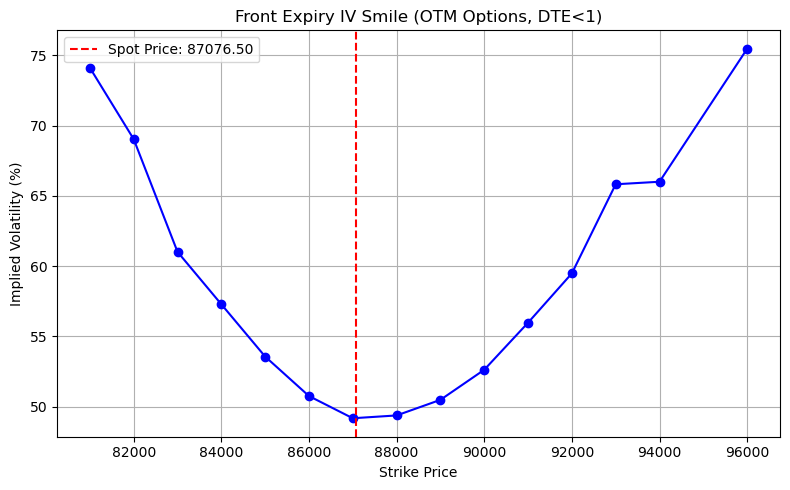

In [42]:
S = get_deribit_index_price("BTC")
plot_front_expiry_smile(df, current_price=S)

In [43]:
df2 = build_vol_surface("BTC")
df2.head()

,strike,dte,mark_iv,calc_iv,option_type
0,190000.0,191.72,51.58,52.826313,call
1,140000.0,9.72,81.22,81.367942,call
2,108000.0,44.72,43.54,44.149335,call
3,120000.0,191.72,46.24,48.259051,call
4,87000.0,0.72,49.15,48.993738,put


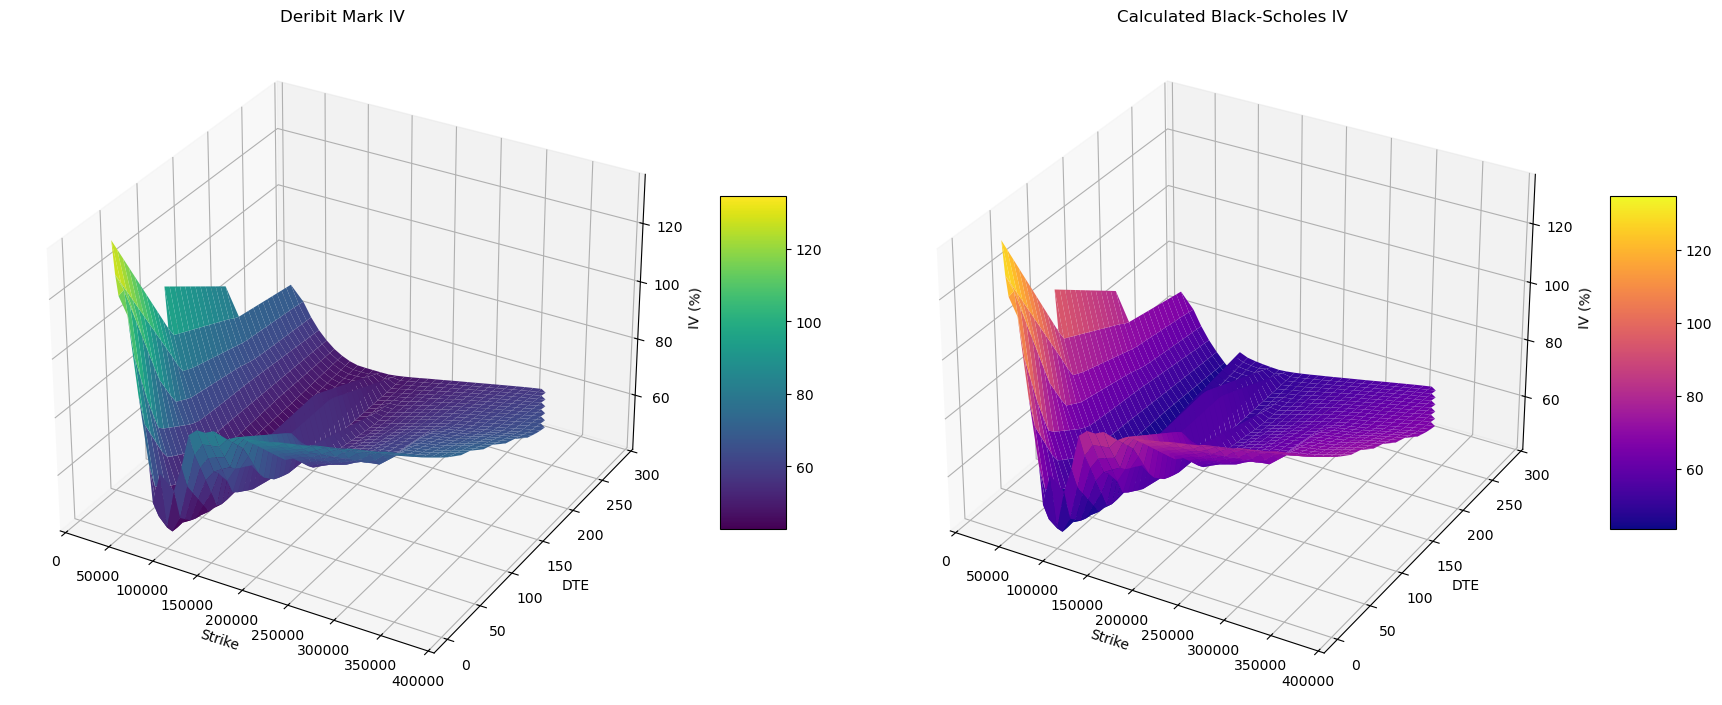

In [44]:
plot_vol_surface_comparison(df2)

In [45]:
def vol_surface_to_var(df, S):
    """
    Convert implied volatility surface to total implied variance with log-moneyness.

    Args:
        df (pd.DataFrame): DataFrame with columns:
            - "strike": option strike prices
            - "dte": days to expiration (in days, float)
            - "mark_iv": implied volatility (annualized, decimal)
        S (float): Current spot or forward price of the underlying asset.

    Returns:
        pd.DataFrame: DataFrame with columns:
            - "strike": log-moneyness (log(strike / S))
            - "dte": time to expiration
            - "mark_total_ivar": total implied variance = iv² × dte
    """
    df_var = pd.DataFrame()
    df_var["log_moneyness"] = np.log(df["strike"]/S)
    df_var["dte"] = df["dte"]
    df_var["mark_total_ivar"] = df["mark_iv"]**2 * (df["dte"]/365.0)

    return df_var

def build_front_expiry_ivar_smile(currency="BTC"):
    """
    Builds a DataFrame containing only front expiry (DTE<1) call options total implied variance data.

    Parameters:
    currency (str): The currency symbol (e.g., "BTC", "ETH").

    Returns:
    pd.DataFrame: Filtered DataFrame with columns ['log_moneyness', 'dte', 'mark_total_ivar'] for front expiry.
    """
    vol_surface = build_vol_surface(currency)
    S = get_deribit_index_price(currency)
    var_surface = vol_surface_to_var(vol_surface, S)

    front_expiry_df = var_surface[var_surface["dte"] == min(var_surface["dte"])].sort_values("log_moneyness")

    return front_expiry_df

def plot_total_ivar_surface(df):
    """
    Plots a 3D volatility surface using log-moneyness, days to expiry (DTE), and total implied variance.

    Parameters:
    df (pd.DataFrame): DataFrame containing columns 'log_moneyness', 'dte', and 'mark_total_ivar'.
    """
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Pivot data into grid
    X = df['log_moneyness']
    Y = df['dte']
    Z = df['mark_total_ivar']

    # Convert to numpy arrays
    xi = np.linspace(X.min(), X.max(), 40)
    yi = np.linspace(Y.min(), Y.max(), 40)
    xi, yi = np.meshgrid(xi, yi)

    zi = griddata((X, Y), Z, (xi, yi), method='linear')

    surf = ax.plot_surface(xi, yi, zi, cmap='viridis', edgecolor='none')
    ax.set_xlabel('Log Moneyness')
    ax.set_ylabel('Days to Expiry')
    ax.set_zlabel('Total Implied Variance (%)')
    ax.set_title('Deribit Total Variance Surface')
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.tight_layout()
    plt.show()

def plot_front_expiry_ivar_smile(df):
    """
    Plots the total implied variance smile.

    Parameters:
    df (pd.DataFrame): DataFrame returned by build_front_expiry_ivar_smile().
    """
    plt.figure(figsize=(8, 5))
    plt.plot(df["log_moneyness"], df["mark_total_ivar"], marker='o', linestyle='-', color='blue')
    
    # Mark ATM (Log Moneyness = 0)
    plt.axvline(x=0, color='red', linestyle='--', label='ATM (Log Moneyness = 0)')
    plt.legend()
    
    plt.title("Front Expiry Total Implied Variance Smile (OTM Options, DTE<1)")
    plt.xlabel("Log Moneyness")
    plt.ylabel("Total Implied Variance (%)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [46]:

S = get_deribit_index_price()

df_var_1 = vol_surface_to_var(df2, S)
df_var_1.head()

,log_moneyness,dte,mark_total_ivar
0,0.780242,191.72,1397.453068
1,0.474861,9.72,175.670716
2,0.215350,44.72,232.266074
3,0.320710,191.72,1123.078742
4,-0.000874,0.72,4.765261


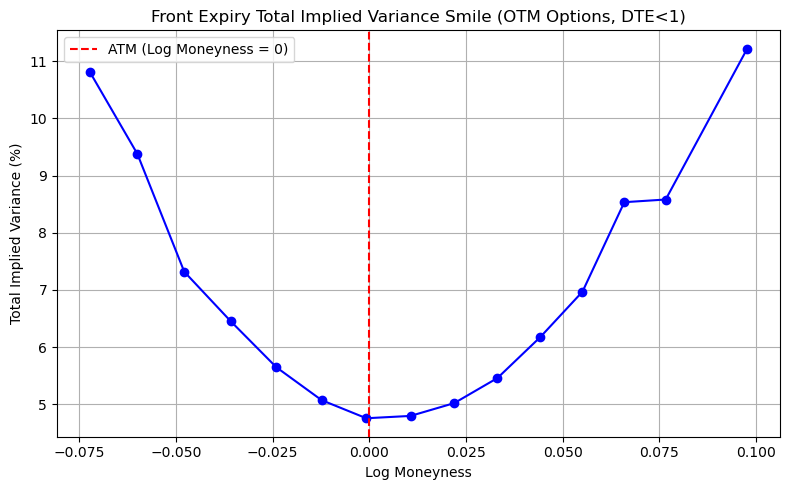

In [47]:
df_var = build_front_expiry_ivar_smile()
plot_front_expiry_ivar_smile(df_var)

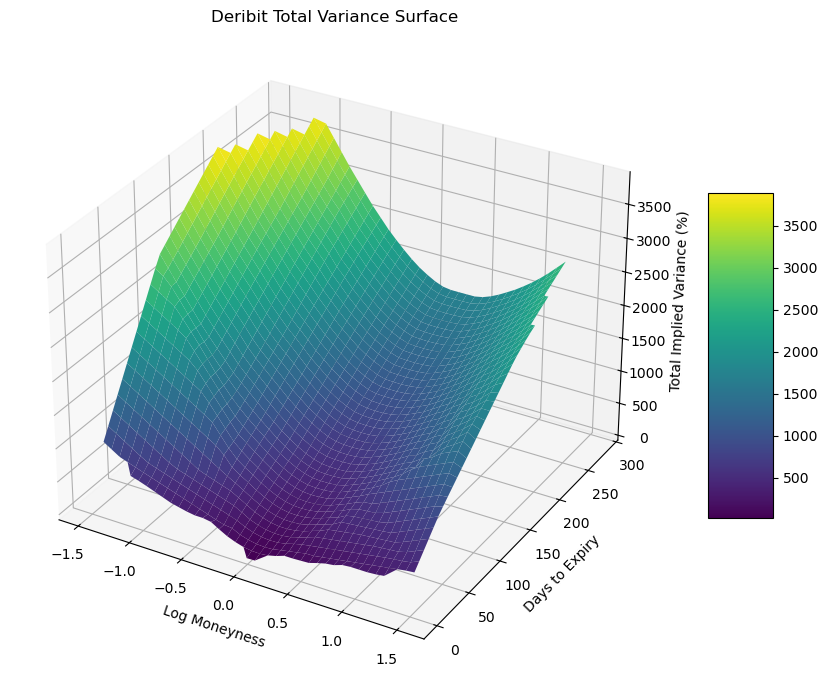

In [48]:
# Build the full surface, not just front expiry
vol_surface = df2

df_var_surface = vol_surface_to_var(vol_surface, S)
plot_total_ivar_surface(df_var_surface)
